# AIC Quant Competition: A Guide to Building Your Bot

Welcome to the AIC Quant Competition! This notebook is designed to help you prepare for your presentation on building a high-performing trading bot. 

We won't give away a "perfect" solution, but we will cover the essential concepts you need to get started:
1.  **Understanding the Goal:** What is the Sharpe Ratio and why does it matter?
2.  **The Competition Framework:** How your bot is structured.
3.  **Data Science: What is this Data?** How to analyze the underlying data distribution.
4.  **Strategy Families:** An introduction to three common approaches based on your analysis.
5.  **Pro-Tips:** Key considerations for risk, state management, and leverage.

Let's get started!

## 1. Understanding the Goal: The Sharpe Ratio

The competition is judged on one thing: the **Sharpe Ratio**. Your bot doesn't just need to make money; it needs to make money *consistently*.

The Sharpe Ratio (SR) measures **risk-adjusted return**. As the `README.md` states, the formula is:

$$SR = \frac{R}{\sigma}$$

Where:
* **R** = Your strategy's average returns (we assume the risk-free rate is 0).
* **σ** (sigma) = The standard deviation of your strategy's returns (i.e., its volatility).

**What does this mean for you?**

* A **high** Sharpe Ratio is good.
* You can increase your SR by **increasing returns (R)** or **decreasing volatility (σ)**.
* A strategy that makes $100 every single day will have a *much* higher Sharpe Ratio than a strategy that makes $20,000 one day and loses $19,000 the next, even if their total profit is similar.

**The takeaway:** Avoid high-risk, high-volatility bets. Aim for consistent, steady gains. Your risk management is just as important as your entry/exit signals.

In [3]:
import numpy as np

def calculate_sharpe(returns: np.ndarray) -> float:
    """Calculates the annualized Sharpe ratio from a series of returns."""
    
    periods_per_year = 252
    
    if len(returns) < 2:
        return 0.0

    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    
    if std_dev == 0:
        # In real markets, this rarely happens - handle gracefully
        return float('inf') if mean_return > 0 else 0.0
    
    # Annualize
    annualized_mean_return = mean_return * periods_per_year
    annualized_std_dev = std_dev * np.sqrt(periods_per_year)
    
    sharpe = annualized_mean_return / annualized_std_dev
    return sharpe

# --- REALISTIC Example --- 
# Strategy A: Consistent but realistic gains (low volatility)
returns_a = np.array([0.001, 0.0008, 0.0012, 0.0009, 0.0011])  # ~0.1% daily with small variation

# Strategy B: Same average return but much higher volatility  
returns_b = np.array([0.003, -0.002, 0.004, -0.001, 0.001])   # Same mean but wild swings

print(f"Strategy A (Steady): Average Return = {np.mean(returns_a):.4f}, Volatility = {np.std(returns_a):.4f}")
print(f"Strategy B (Volatile): Average Return = {np.mean(returns_b):.4f}, Volatility = {np.std(returns_b):.4f}")
print("-----")
print(f"Strategy A Sharpe: {calculate_sharpe(returns_a):.2f}")
print(f"Strategy B Sharpe: {calculate_sharpe(returns_b):.2f}")

Strategy A (Steady): Average Return = 0.0010, Volatility = 0.0001
Strategy B (Volatile): Average Return = 0.0010, Volatility = 0.0023
-----
Strategy A Sharpe: 112.25
Strategy B Sharpe: 6.96


In [5]:
# Example more relevant to the competition
def competition_context_example():
    print("Competition Context: Why Sharpe Ratio Matters")
    print("=" * 50)
    
    # Two strategies with similar total returns but different patterns
    days = 63  # Typical competition duration (~3 months)
    
    # Strategy 1: Consistent performer
    strategy_1_returns = np.random.normal(0.0015, 0.002, days)  # 0.15% ± 0.2% daily
    
    # Strategy 2: Erratic - big wins and big losses  
    strategy_2_returns = np.concatenate([
        np.random.normal(0.008, 0.001, 10),   # Big wins
        np.random.normal(-0.006, 0.001, 10),  # Big losses  
        np.random.normal(0.001, 0.002, 43)    # Normal days
    ])
    np.random.shuffle(strategy_2_returns)
    
    total_return_1 = np.sum(strategy_1_returns)
    total_return_2 = np.sum(strategy_2_returns)
    
    sharpe_1 = calculate_sharpe(strategy_1_returns)
    sharpe_2 = calculate_sharpe(strategy_2_returns)
    
    print(f"Strategy 1 (Consistent): Total Return = {total_return_1:.3f}, Sharpe = {sharpe_1:.2f}")
    print(f"Strategy 2 (Erratic):    Total Return = {total_return_2:.3f}, Sharpe = {sharpe_2:.2f}")
    print(f"\nEven with similar total returns, Strategy 1 wins due to better Sharpe!")

competition_context_example()

Competition Context: Why Sharpe Ratio Matters
Strategy 1 (Consistent): Total Return = 0.083, Sharpe = 10.69
Strategy 2 (Erratic):    Total Return = 0.064, Sharpe = 3.61

Even with similar total returns, Strategy 1 wins due to better Sharpe!


## 2. The Competition Framework: A Quick Recap

All your logic must live in `submission/submission.py`. The evaluator will import your code and do two things:

1.  Call `build_trader()`: This function must return an *instance* of your trader class.
2.  Call `your_trader.on_quote(market, portfolio)`: This method is called *for every new timestep*. This is your main event loop. All your logic goes here.

### The Base Case: `submission.py`

The provided `submission.py` gives us a simple `TestTrader`. This is a great starting point.

```python
import logging
try:
    from pricing.Market import Market
    from pricing.Portfolio import Portfolio
except ImportError:
    class Market: pass
    class Portfolio: pass

logger = logging.getLogger("local_eval")

class TestTrader:
    """
    A simple example trader.
    """
    def __init__(self) -> None:
        logger.debug("TestTrader initialized.")

    def on_quote(self, market: Market, portfolio: Portfolio) -> None:
        """
        This is the main event loop.
        """
        product = "INTERESTingProduct"

        has_long_position = product in portfolio.positions and portfolio.positions[product] > 0
        price = market.quotes[product]['price']

        if not has_long_position and price < 3.0:
            portfolio.buy(product, 10000)
        elif has_long_position and price > 4.5:
            # Note: The original only sells if price > 4.5. 
            # We'll modify this in our examples to sell *all* shares.
            portfolio.sell(product, portfolio.positions[product])

def build_trader(universe) -> TestTrader:
    return TestTrader(universe)
```

This trader is simple but has a major flaw: it only knows the *current* price. To build a real strategy, we need to track **history**.

## 3. Data Science: What is this Data? 🕵️‍♂️

Before you can build a strategy, you must understand the data. The `README.md` mentions this is **synthetic price data**. This means the we *designed* it to have certain properties.

Your goal is to be a detective and figure out what those properties are. Use the `src/notebooks/data_exploration_template.ipynb` to load `data/comp_data.csv` and investigate.

**Key Questions to Answer:**

1.  **Is the data stationary or non-stationary?**
    * A **stationary** series (like white noise) tends to return to a long-term mean. This is good for **Mean Reversion** strategies.
    * A **non-stationary** series (like a "random walk") has no long-term mean and can drift forever. This is good for **Trend Following** strategies.
    * **How to test:** Use a statistical test like the **Augmented Dickey-Fuller (ADF)** test. The `statsmodels` library (available in Docker) can do this.

2.  **Are the *returns* autocorrelated?**
    * **Autocorrelation** means a price's future movement depends on its *past* movements.
    * **Positive Autocorrelation (Momentum):** A positive return today suggests a positive return tomorrow. (Good for Trend Following).
    * **Negative Autocorrelation (Mean Reversion):** A positive return today suggests a negative return tomorrow. (Good for Mean Reversion).
    * **How to test:** Plot the **Autocorrelation Function (ACF)**. 

3.  **Are the two products related?**
    * The data gives you `INTERESTingProduct` and `James_Fund_007`. Is this a coincidence?
    * **Correlation:** Do they move together? A simple `df.corr()` will show this.
    * **Cointegration:** A stronger bond. Do they have a long-run equilibrium relationship? This is the basis for **Statistical Arbitrage**.
    * **How to test:** Use the Engle-Granger cointegration test (also in `statsmodels`).

--- Data Description ---
          timestep  INTERESTingProduct  James_Fund_007
count  2000.000000         2000.000000     2000.000000
mean    999.500000            3.568824       99.840566
std     577.494589            0.600829        0.186717
min       0.000000            2.297710       99.566293
25%     499.750000            3.003411       99.650652
50%     999.500000            3.670313       99.848405
75%    1499.250000            4.111866      100.008425
max    1999.000000            4.532473      100.201642

--- ADF Test for INTERESTingProduct Price ---
ADF Statistic: -0.8129635195032165
p-value: 0.8152844419667111

--- ADF Test for James_Fund_007 Price ---
ADF Statistic: -1.6813930593757953
p-value: 0.44072392821000045

--- ACF Plot for INTERESTingProduct Returns ---


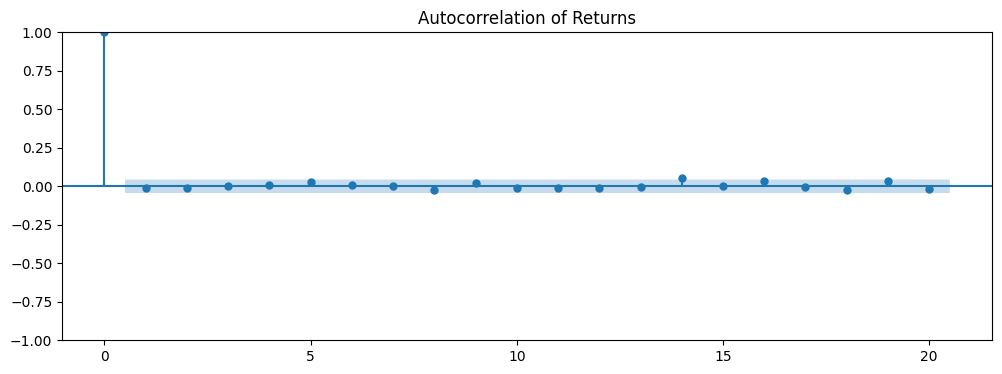


--- ACF Plot for INTERESTingProduct Returns ---


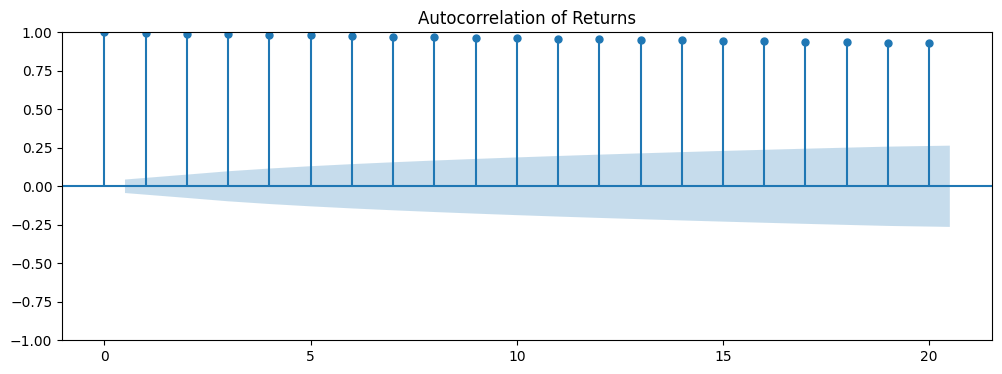


--- Correlation Matrix ---
                    INTERESTingProduct  James_Fund_007
INTERESTingProduct            1.000000        0.288744
James_Fund_007                0.288744        1.000000


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Load the data (make sure you've run 'docker ... sync-data' first!)
try:
    df = pd.read_csv("data/comp_data.csv")
except FileNotFoundError:
    print("data/comp_data.csv not found. Make sure to run the sync-data command from the README.")
    df = pd.DataFrame() # Create empty df to avoid errors

if not df.empty:
    print("--- Data Description ---")
    print(df.describe()) #
    
    # --- 1. Stationarity Test (ADF) --- 
    # We test the *price* of INTERESTingProduct
    product_A_price = df["INTERESTingProduct"].dropna()
    product_B_price = df["James_Fund_007"].dropna()
    adf_result = adfuller(product_A_price)
    print(f"\n--- ADF Test for INTERESTingProduct Price ---")
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')

    adf_result_B = adfuller(product_B_price)
    print(f"\n--- ADF Test for James_Fund_007 Price ---")
    print(f'ADF Statistic: {adf_result_B[0]}')
    print(f'p-value: {adf_result_B[1]}')

    # A high p-value (e.g., > 0.05) suggests the data is non-stationary (like a random walk).
    # A low p-value (e.g., < 0.05) suggests the data is stationary (mean-reverting).

    # --- 2. Autocorrelation Test (ACF) ---
    # We test the *returns*, not the price.
    product_A_returns = product_A_price.pct_change().dropna()
    
    print("\n--- ACF Plot for INTERESTingProduct Returns ---")
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(product_A_returns, lags=20, ax=ax)
    plt.title("Autocorrelation of Returns")
    plt.show()

    product_B_returns = product_B_price.pct_change().dropna()
    
    print("\n--- ACF Plot for INTERESTingProduct Returns ---")
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(product_B_returns, lags=20, ax=ax)
    plt.title("Autocorrelation of Returns")
    plt.show()
    # Spikes outside the blue shaded area are statistically significant.
    # A significant spike at lag 1 (positive or negative) gives you a big clue!

    # --- 3. Correlation Test ---
    print(f"\n--- Correlation Matrix ---")
    print(df[['INTERESTingProduct', 'James_Fund_007']].corr()) #
    # Is there a strong relationship here? What could that imply?

## 4. Strategy Approaches (Based on your Analysis)

Your data science findings should directly lead you to a strategy. Because your trader object is *persistent* (it's created once and `on_quote` is called many times), you can store data on `self`.

> **💡 Pro-Tip: State Management**
> Use your class's `__init__` method to set up variables to track history. A `deque` (double-ended queue) from the `collections` module is perfect for this, as it can be given a `maxlen` to automatically discard old prices.

Let's explore three strategy families based on what you *might* find.

### Approach 1: Trend Following (Momentum)

**When to use:** Your ADF test shows the *price* is **non-stationary** (p-value > 0.05) AND your ACF plot shows *returns* have **positive autocorrelation** at lag 1.

**Concept:** "The trend is your friend." If a price is going up, it will likely continue to go up. If it's going down, it will continue to go down.

**How to Measure:** The most common method is a **Simple Moving Average (SMA) Crossover**.
* **Fast SMA:** The average price over a *short* window (e.g., 5 timesteps).
* **Slow SMA:** The average price over a *long* window (e.g., 20 timesteps).

**Strategy Logic:**
* **Buy Signal:** When the Fast SMA crosses *above* the Slow SMA.
* **Sell Signal:** When the Fast SMA crosses *below* the Slow SMA.

Let's build a trader that does this.

In [5]:
import numpy as np
from collections import deque
from src.pricing.Market import Market
from src.pricing.Portfolio import Portfolio

# --- Setup Logger ---
import logging
logger = logging.getLogger("local_eval")

class MomentumTrader:
    def __init__(self, slow_window=20, fast_window=5):
        logger.debug("MomentumTrader initialized.")
        
        self.product = "INTERESTingProduct"
        
        # --- State Management --- 
        self.slow_window = slow_window
        self.fast_window = fast_window
        
        # Use a deque to automatically store the last `slow_window` prices
        self.price_history = deque(maxlen=self.slow_window)
        
        # Track our SMAs
        self.slow_sma = 0
        self.fast_sma = 0

    def on_quote(self, market: Market, portfolio: Portfolio) -> None:
        
        # Get the current price and add it to our history
        try:
            price = market.quotes[self.product]['price']
        except KeyError:
            return # No quote for this product yet
        self.price_history.append(price)

        # --- Strategy Logic --- 

        # Don't trade until we have enough data to fill the slow window
        if len(self.price_history) < self.slow_window:
            return

        # Calculate the new SMAs
        # Note: np.mean is fast and available in the competition environment
        new_slow_sma = np.mean(self.price_history)
        new_fast_sma = np.mean(list(self.price_history)[-self.fast_window:])
        
        # Check for position
        has_long_position = self.product in portfolio.positions and portfolio.positions[self.product] > 0

        # --- Crossover Signals --- 
        # Check if a crossover *just happened*
        if self.fast_sma <= self.slow_sma and new_fast_sma > new_slow_sma:
            # BUY SIGNAL: Fast just crossed above slow
            if not has_long_position:
                # Calculate position size (e.g., 20% of our cash)
                position_size = (portfolio.cash * 0.20) / price
                portfolio.buy(self.product, int(position_size)) #
                logger.info(f"BUY SIGNAL: Fast SMA {new_fast_sma:.2f} crossed above Slow SMA {new_slow_sma:.2f}")

        elif self.fast_sma >= self.slow_sma and new_fast_sma < new_slow_sma:
            # SELL SIGNAL: Fast just crossed below slow
            if has_long_position:
                # Sell our entire position
                portfolio.sell(self.product, portfolio.positions[self.product]) #
                logger.info(f"SELL SIGNAL: Fast SMA {new_fast_sma:.2f} crossed below Slow SMA {new_slow_sma:.2f}")

        # Update old SMA values for the next tick
        self.slow_sma = new_slow_sma
        self.fast_sma = new_fast_sma

# Factory function for this trader
def build_trader(universe) -> MomentumTrader:
    # You would find these parameters by analyzing comp_data.csv locally!
    return MomentumTrader(slow_window=20, fast_window=5)


### Approach 2: Mean Reversion (Oscillators)

**When to use:** Your ADF test shows the *price* is **stationary** (p-value < 0.05) OR your ACF plot shows *returns* have **negative autocorrelation** at lag 1.

**Concept:** "What goes up must come down." This strategy assumes that a product's price will revert to its historical average. It works best in markets that are "range-bound".

**How to Measure:** **Bollinger Bands** are a great tool for this.
* **Middle Band:** A Simple Moving Average (e.g., 20-period).
* **Upper Band:** Middle Band + (k * standard_deviation)
* **Lower Band:** Middle Band - (k * standard_deviation)
    (Usually, k=2)

**Strategy Logic:**
* **Sell Signal:** Price crosses *above* the Upper Band (it's "overbought" and likely to fall).
* **Buy Signal:** Price crosses *below* the Lower Band (it's "oversold" and likely to rise).
* **Exit Signal:** Price crosses the Middle Band.

In [6]:
import numpy as np
from collections import deque

class MeanReversionTrader:
    def __init__(self, window=20, k=2.0):
        logger.debug("MeanReversionTrader initialized.")
        
        self.product = "INTERESTingProduct"
        self.window = window
        self.k = k
        
        self.price_history = deque(maxlen=self.window)
        self.position_size = 10000 # Fixed position size for this example

    def on_quote(self, market: Market, portfolio: Portfolio) -> None:
        
        try:
            price = market.quotes[self.product]['price']
        except KeyError:
            return # No quote yet
        self.price_history.append(price)

        if len(self.price_history) < self.window:
            return

        # Calculate Bollinger Bands
        prices_arr = np.array(self.price_history)
        middle_band = np.mean(prices_arr)
        std_dev = np.std(prices_arr)
        
        upper_band = middle_band + (self.k * std_dev)
        lower_band = middle_band - (self.k * std_dev)

        # Check for position
        position = portfolio.positions.get(self.product, 0)

        # --- Strategy Logic --- 

        if price > upper_band:
            # SELL SIGNAL (Overbought)
            # We can either sell our long position or open a short position
            if position > 0:
                portfolio.sell(self.product, position) # Close long
            # Example: Open a short position
            # portfolio.sell(self.product, self.position_size) 
            logger.info(f"SELL SIGNAL: Price {price:.2f} > Upper Band {upper_band:.2f}")

        elif price < lower_band:
            # BUY SIGNAL (Oversold)
            if position == 0: # Only buy if we have no position
                portfolio.buy(self.product, self.position_size)
            logger.info(f"BUY SIGNAL: Price {price:.2f} < Lower Band {lower_band:.2f}")
        
        elif price > middle_band and position > 0:
            # EXIT LONG: Price crossed back above the mean
            portfolio.sell(self.product, position)
            logger.info(f"EXIT LONG: Price {price:.2f} > Middle Band {middle_band:.2f}")

        # (You would also add logic here to exit a short position)

def build_trader() -> MeanReversionTrader:
    # Find window and k by analyzing comp_data.csv!
    return MeanReversionTrader(window=20, k=2.0)


### Approach 3: Statistical Arbitrage (Pairs Trading)

**When to use:** Your data analysis shows the two products are **cointegrated** (or at least very highly correlated).

**Concept:** This is a more advanced form of mean reversion. You find two products that tend to move together. You then trade the *spread* (the difference or ratio) between them, assuming it will revert to its historical mean.

**How to Measure:**
1.  **Offline (in a notebook):** Use the `comp_data.csv` to analyze `INTERESTingProduct` and `James_Fund_007`. 
2.  Calculate the spread (e.g., `spread = price_A - (hedge_ratio * price_B)`). You can find the `hedge_ratio` using linear regression.
3.  Find the **historical mean** and **standard deviation** of this *spread*.
4.  Run an ADF test *on the spread*. If the spread is **stationary** (p-value < 0.05), this strategy is viable.

**Strategy Logic (in `on_quote`):**
1.  Calculate the *current* spread using your hard-coded `hedge_ratio`.
2.  **Sell Spread Signal:** If `current_spread > mean + (k * std_dev)`. (Sell A, Buy B).
3.  **Buy Spread Signal:** If `current_spread < mean - (k * std_dev)`. (Buy A, Sell B).
4.  **Exit Signal:** If the spread crosses the mean.

In [ ]:
import numpy as np

class PairsTrader:
    def __init__(self, hedge_ratio, spread_mean, spread_std, k=1.5):
        logger.debug("PairsTrader initialized.")
        
        # --- Parameters found from OFFLINE analysis --- 
        self.hedge_ratio = hedge_ratio
        self.spread_mean = spread_mean
        self.spread_std = spread_std
        self.k = k
        
        self.prod_A = "INTERESTingProduct"
        self.prod_B = "James_Fund_007"
        
        self.position_size_A = 10000
        # Calculate B's size based on the hedge ratio
        self.position_size_B = int(self.position_size_A * self.hedge_ratio)

    def on_quote(self, market: Market, portfolio: Portfolio) -> None:
        
        try:
            price_A = market.quotes[self.prod_A]['price']
            price_B = market.quotes[self.prod_B]['price']
        except KeyError:
            return # Not all data is available yet

        # --- Strategy Logic --- 
        current_spread = price_A - (self.hedge_ratio * price_B)
        
        upper_band = self.spread_mean + (self.k * self.spread_std)
        lower_band = self.spread_mean - (self.k * self.spread_std)

        # Check if we are already in a position (we'll just check one product)
        position_A = portfolio.positions.get(self.prod_A, 0)

        if current_spread > upper_band:
            # SELL SPREAD (Spread is too high, short it)
            # Short A, Long B
            if position_A == 0:
                portfolio.sell(self.prod_A, self.position_size_A)
                portfolio.buy(self.prod_B, self.position_size_B)
                logger.info(f"SELL SPREAD: {current_spread:.2f} > {upper_band:.2f}")

        elif current_spread < lower_band:
            # BUY SPREAD (Spread is too low, long it)
            # Long A, Short B
            if position_A == 0:
                portfolio.buy(self.prod_A, self.position_size_A)
                portfolio.sell(self.prod_B, self.position_size_B)
                logger.info(f"BUY SPREAD: {current_spread:.2f} < {lower_band:.2f}")

        elif abs(current_spread - self.spread_mean) < (self.spread_std * 0.1): # Exit near the mean
            # EXIT SPREAD
            if position_A > 0: # We are long A, short B
                portfolio.sell(self.prod_A, position_A)
                portfolio.buy(self.prod_B, abs(portfolio.positions.get(self.prod_B, 0)))
            elif position_A < 0: # We are short A, long B
                portfolio.buy(self.prod_A, abs(position_A))
                portfolio.sell(self.prod_B, portfolio.positions.get(self.prod_B, 0))
            logger.info(f"EXIT SPREAD: {current_spread:.2f} near mean {self.spread_mean:.2f}")


def build_trader() -> PairsTrader:
    # --- IMPORTANT --- 
    # These values are JUST EXAMPLES. 
    # You MUST calculate them by running regression and stats tests on `comp_data.csv`
    
    # From our data notebook, a ratio of ~0.0357 might be a good start for the hedge ratio
    EXAMPLE_RATIO = 0.0357
    # You would then calculate the mean/std of the *spread* (PriceA - 0.0357 * PriceB)
    EXAMPLE_MEAN = -0.01 
    EXAMPLE_STD = 0.2
    
    return PairsTrader(EXAMPLE_RATIO, EXAMPLE_MEAN, EXAMPLE_STD, k=1.5)


## 5. Final Pro-Tips

1.  **Do Your Homework:** Use the `data_exploration_template.ipynb` to analyze `comp_data.csv`. This is not optional. You cannot build a good strategy without understanding the data (e.g., is it trending? range-bound? are the assets correlated?).

2.  **Risk Management is Key:** Remember the Sharpe Ratio! 
    * **Position Sizing:** Don't go all-in on one trade. The `portfolio.buy(product, size)` method has a leverage check. Use it, but don't get close to the 10x limit on every trade. A smaller, more consistent position will likely have a better Sharpe Ratio.
    * **Diversification:** Can you run two or three *different* strategies at once on different products? A pairs trading strategy and a momentum strategy together might be less volatile than either one alone.

3.  **Local Evaluation:** Use the `local-eval` docker command! The `README.md` explains it well. This runs your bot using the *exact same logic* as the cloud evaluator. Test, test, and test again before submitting.
    ```bash
    # Make sure your code is in submission/submission.py
    docker run --rm -v "$(pwd):/usr/src/app" trading-comp-env local-eval
    ```

4.  **Read the Libs:** The competition allows `numpy` and `pandas`. `numpy` is incredibly fast for math. Using `np.mean()` and `np.std()` on your `deque` of prices is much better than calculating it with Python loops.

--- 

### Good luck, and have fun!